# Análise de Dados SFI2 com Parquet

Este notebook demonstra como usar o arquivo Parquet consolidado para análises de dados do experimento SFI2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurando o estilo de visualização
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

## Carregando os dados

O formato Parquet é extremamente eficiente para carregar grandes conjuntos de dados.

In [2]:
# Carregar o arquivo Parquet consolidado
df = pd.read_parquet('data/processed/sfi2_paper_consolidated.parquet')

# Exibir informações básicas
print(f"Dimensões do DataFrame: {df.shape}")
print(f"\nUtilização de memória: {df.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB")
df.info()

Dimensões do DataFrame: (510167, 6)

Utilização de memória: 142.26 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510167 entries, 0 to 510166
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  510167 non-null  datetime64[ns]
 1   value      510167 non-null  float64       
 2   round_id   510167 non-null  object        
 3   phase      510167 non-null  object        
 4   component  510167 non-null  object        
 5   metric     510167 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 23.4+ MB


In [3]:
# Visualizar as primeiras linhas
df.head()

,timestamp,value,round_id,phase,component,metric
0,2025-06-21 23:03:49,1.651515,round-1,1 - Baseline,accepted,nginx_connections_total
1,2025-06-21 23:03:55,1.779115,round-1,1 - Baseline,accepted,nginx_connections_total
2,2025-06-21 23:04:01,1.778461,round-1,1 - Baseline,accepted,nginx_connections_total
3,2025-06-21 23:04:07,1.887879,round-1,1 - Baseline,accepted,nginx_connections_total
4,2025-06-21 23:04:13,1.851515,round-1,1 - Baseline,accepted,nginx_connections_total


## Explorando o conjunto de dados

Vamos explorar a estrutura e distribuição dos dados.

In [4]:
# Valores únicos por coluna categórica
print(f"Rounds: {df['round_id'].nunique()}")
print(f"Fases: {df['phase'].nunique()}")
print(f"Componentes: {df['component'].nunique()}")
print(f"Métricas: {df['metric'].nunique()}")

# Distribuição de dados por round
round_counts = df['round_id'].value_counts().sort_index()
print(f"\nDistribuição por round:\n{round_counts}")

# Distribuição por fase
phase_counts = df['phase'].value_counts().sort_index()
print(f"\nDistribuição por fase:\n{phase_counts}")

Rounds: 3
Fases: 7
Componentes: 17
Métricas: 35

Distribuição por round:
round_id
round-1    169744
round-2    169962
round-3    170461
Name: count, dtype: int64

Distribuição por fase:
phase
1 - Baseline          34833
2 - CPU Noise         81160
3 - Memory Noise      85768
4 - Network Noise     88216
5 - Disk Noise        88246
6 - Combined Noise    91264
7 - Recovery          40680
Name: count, dtype: int64


## Preparação dos dados

Vamos realizar algumas operações de preparação dos dados para análise.

In [5]:
# Verificar e tratar valores infinitos ou NaN
print(f"Valores infinitos no DataFrame: {np.isinf(df['value']).sum()}")
print(f"Valores NaN no DataFrame: {df['value'].isna().sum()}")

# Criar uma cópia com valores infinitos tratados
df_clean = df.copy()
df_clean['value'] = df_clean['value'].replace([np.inf, -np.inf], np.nan)

# Estatísticas básicas dos valores
print("\nEstatísticas dos valores limpos:")
print(df_clean['value'].describe())

Valores infinitos no DataFrame: 2210
Valores NaN no DataFrame: 0

Estatísticas dos valores limpos:
count    5.079570e+05
mean     2.269870e+08
std      5.804840e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.049826e-03
75%      7.500379e+02
max      2.626077e+09
Name: value, dtype: float64


## Análise por Métricas Específicas

Vamos selecionar algumas métricas importantes e analisar seu comportamento durante as diferentes fases do experimento.

In [6]:
# Listar as métricas disponíveis
print("Métricas disponíveis:")
for metric in sorted(df['metric'].unique()):
    print(f"- {metric}")

Métricas disponíveis:
- cpu_tenant_dsk_vs_other_ratio
- cpu_throttled_ratio
- cpu_throttled_time
- cpu_usage
- cpu_usage_noisy_victim_ratio
- cpu_usage_variability
- disk_io_tenant_dsk
- disk_io_total
- disk_tenant_dsk_vs_other_ratio
- disk_throughput_total
- jitter_admission_process
- jitter_processing_rate
- latency_bytes_per_request
- memory_usage
- memory_usage_noisy_victim_ratio
- network_dropped
- network_error_rate
- network_packet_rate
- network_receive
- network_total_bandwidth
- network_transmit
- network_usage_noisy_victim_ratio
- nginx_bytes_read
- nginx_bytes_written
- nginx_connections
- nginx_connections_total
- nginx_cpu_usage
- nginx_memory_usage
- nginx_requests_total
- oom_kills
- pod_ready_age
- pod_restarts
- postgres_connections
- postgres_transactions
- resource_dominance_index


In [7]:
# Selecionar uma métrica específica para análise
metric_to_analyze = 'nginx_connections'
component_filter = 'active'

# Filtrar dados
filtered_df = df_clean[
    (df_clean['metric'] == metric_to_analyze) & 
    (df_clean['component'] == component_filter)
]

# Agrupar por fase e calcular estatísticas
phase_stats = filtered_df.groupby(['round_id', 'phase'])['value'].agg(
    ['mean', 'std', 'min', 'max']
).reset_index()

phase_stats

,round_id,phase,mean,std,min,max
0,round-1,1 - Baseline,5.980198,0.199007,4.0,6.0
1,round-1,2 - CPU Noise,6.000000,0.000000,6.0,6.0
2,round-1,3 - Memory Noise,6.000000,0.000000,6.0,6.0
3,round-1,4 - Network Noise,5.989848,0.142494,4.0,6.0
4,round-1,5 - Disk Noise,6.000000,0.000000,6.0,6.0
5,round-1,6 - Combined Noise,6.000000,0.000000,6.0,6.0
6,round-1,7 - Recovery,6.000000,0.000000,6.0,6.0
7,round-2,1 - Baseline,6.000000,0.000000,6.0,6.0
8,round-2,2 - CPU Noise,6.000000,0.000000,6.0,6.0
9,round-2,3 - Memory Noise,6.000000,0.000000,6.0,6.0


## Visualização de Dados

Vamos visualizar como algumas métricas se comportam ao longo das diferentes fases do experimento.

In [8]:
# Função para plotar uma métrica específica
def plot_metric_by_phase(df, metric_name, component_name=None, round_id=None):
    """
    Plota uma métrica específica por fase para um componente e round específicos.
    """
    # Filtrar dados
    query = f"metric == '{metric_name}'"
    if component_name:
        query += f" and component == '{component_name}'"
    if round_id:
        query += f" and round_id == '{round_id}'"
    
    plot_df = df_clean.query(query).copy()
    
    if len(plot_df) == 0:
        print(f"Nenhum dado encontrado para a métrica {metric_name}")
        if component_name:
            print(f"Componentes disponíveis para esta métrica: {df_clean[df_clean['metric'] == metric_name]['component'].unique()}")
        return
    
    # Converter timestamp para datetime se necessário
    if not pd.api.types.is_datetime64_any_dtype(plot_df['timestamp']):
        plot_df['timestamp'] = pd.to_datetime(plot_df['timestamp'])
    
    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plotar por fase
    phases = sorted(plot_df['phase'].unique())
    
    for phase in phases:
        phase_data = plot_df[plot_df['phase'] == phase]
        ax.plot(phase_data['timestamp'], phase_data['value'], label=phase, alpha=0.8)
    
    # Configurar o gráfico
    title = f"{metric_name}"
    if component_name:
        title += f" - {component_name}"
    if round_id:
        title += f" ({round_id})"
    
    ax.set_title(title)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Valor')
    ax.legend(title="Fase")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estatísticas
    stats = plot_df.groupby('phase')['value'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    return stats

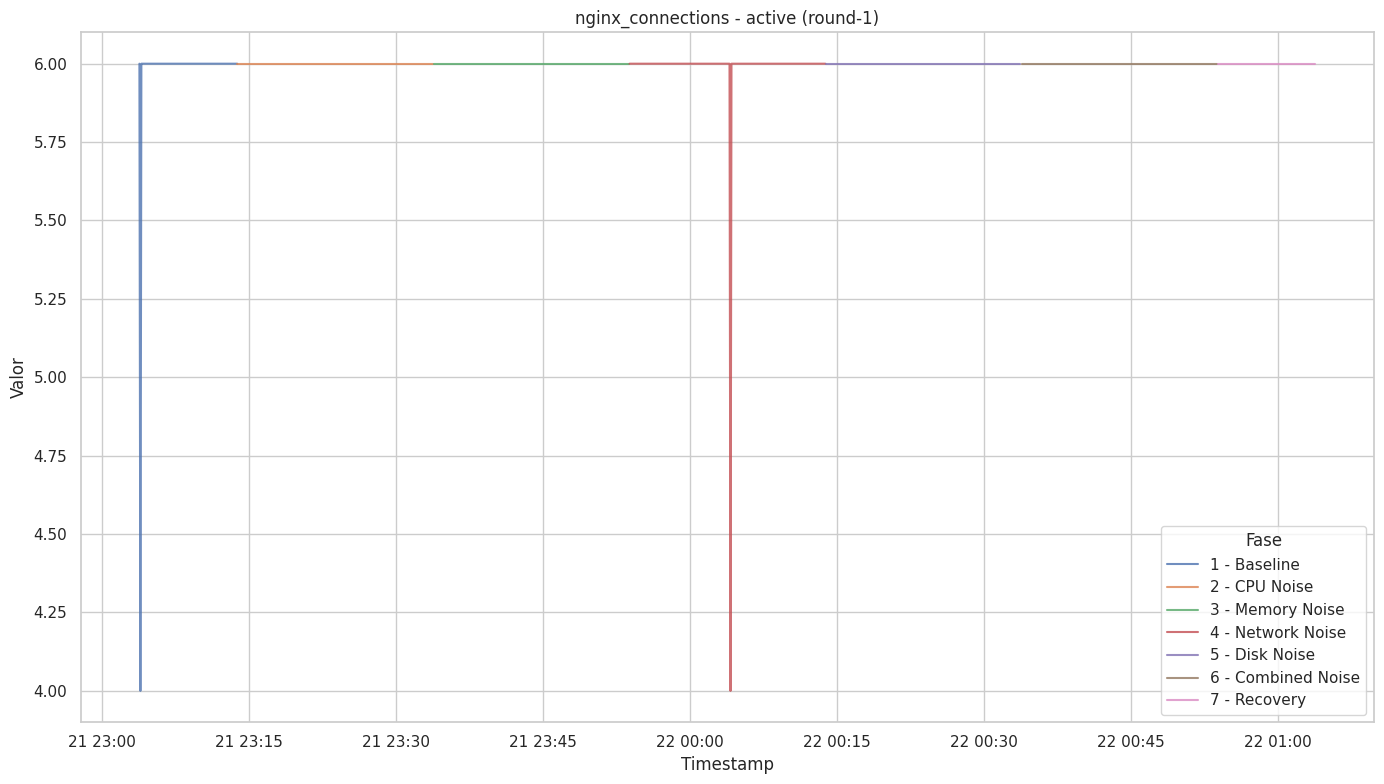

,phase,count,mean,std,min,max
0,1 - Baseline,101,5.980198,0.199007,4.0,6.0
1,2 - CPU Noise,201,6.000000,0.000000,6.0,6.0
2,3 - Memory Noise,201,6.000000,0.000000,6.0,6.0
3,4 - Network Noise,197,5.989848,0.142494,4.0,6.0
4,5 - Disk Noise,190,6.000000,0.000000,6.0,6.0
5,6 - Combined Noise,192,6.000000,0.000000,6.0,6.0
6,7 - Recovery,101,6.000000,0.000000,6.0,6.0


In [9]:
# Analisar conexões Nginx ativas
plot_metric_by_phase(df_clean, 'nginx_connections', 'active', 'round-1')

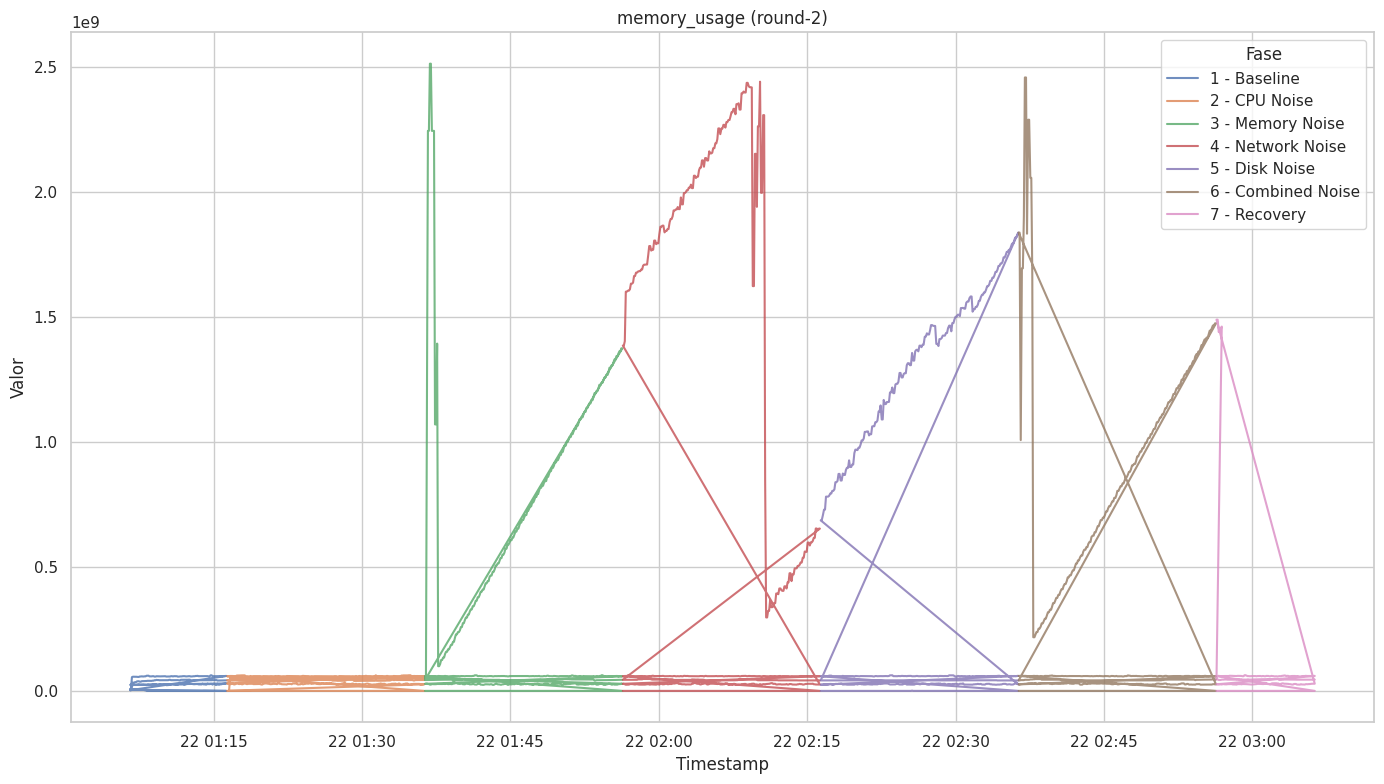

,phase,count,mean,std,min,max
0,1 - Baseline,396,3.341356e+07,2.143278e+07,2138112.0,6.451610e+07
1,2 - CPU Noise,1003,3.835065e+07,2.100058e+07,2146304.0,6.484787e+07
2,3 - Memory Noise,1000,1.869401e+08,3.711919e+08,2146304.0,2.513617e+09
3,4 - Network Noise,975,3.436107e+08,6.984209e+08,2154496.0,2.441482e+09
4,5 - Disk Noise,945,2.886487e+08,5.276804e+08,2154496.0,1.837367e+09
5,6 - Combined Noise,955,2.130946e+08,4.135471e+08,2146304.0,2.458472e+09
6,7 - Recovery,406,5.634471e+07,1.739628e+08,2154496.0,1.488720e+09


In [10]:
# Comparar uso de memória entre fases
plot_metric_by_phase(df_clean, 'memory_usage', None, 'round-2')

## Comparação entre Rounds

Vamos comparar como uma métrica específica se comporta entre diferentes rounds.

In [11]:
# Função para comparar rounds
def compare_rounds_for_metric(df, metric_name, component_name=None, phase_name=None):
    """
    Compara uma métrica específica entre diferentes rounds para uma fase e componente específicos.
    """
    # Filtrar dados
    query = f"metric == '{metric_name}'"
    if component_name:
        query += f" and component == '{component_name}'"
    if phase_name:
        query += f" and phase == '{phase_name}'"
    
    plot_df = df_clean.query(query).copy()
    
    if len(plot_df) == 0:
        print(f"Nenhum dado encontrado para a métrica {metric_name}")
        return
    
    # Criar gráfico boxplot para comparar rounds
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='round_id', y='value', data=plot_df)
    
    title = f"Comparação de {metric_name}"
    if component_name:
        title += f" - {component_name}"
    if phase_name:
        title += f" (Fase: {phase_name})"
    
    plt.title(title)
    plt.xlabel('Round')
    plt.ylabel('Valor')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Estatísticas por round
    stats = plot_df.groupby('round_id')['value'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    return stats

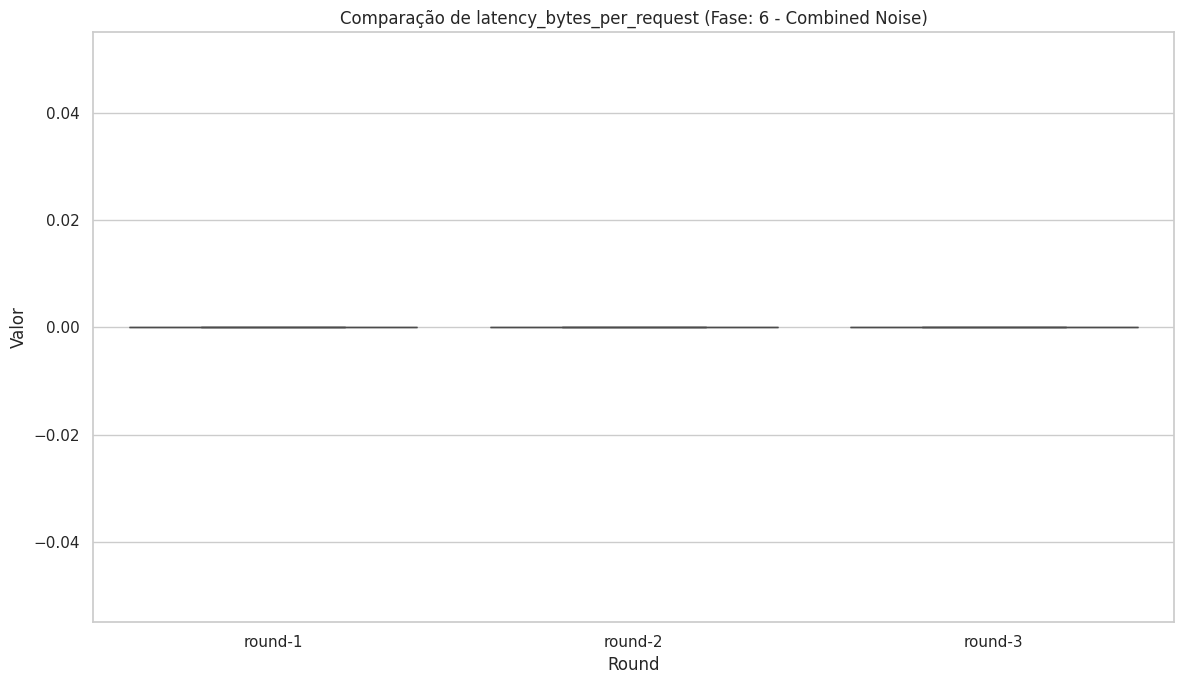

,round_id,count,mean,std,min,max
0,round-1,383,0.0,0.0,0.0,0.0
1,round-2,382,0.0,0.0,0.0,0.0
2,round-3,383,0.0,0.0,0.0,0.0


In [12]:
# Comparar latência entre rounds durante a fase de ruído combinado
compare_rounds_for_metric(df_clean, 'latency_bytes_per_request', None, '6 - Combined Noise')

## Análise de Impacto de Ruído

Vamos analisar o impacto de cada tipo de ruído nas métricas de desempenho.

In [13]:
# Função para analisar o impacto de cada tipo de ruído
def analyze_noise_impact(df, metric_name, component_name=None):
    """
    Analisa o impacto de cada tipo de ruído em uma métrica específica.
    Compara com a linha de base.
    """
    # Filtrar dados
    query = f"metric == '{metric_name}'"
    if component_name:
        query += f" and component == '{component_name}'"
    
    plot_df = df_clean.query(query).copy()
    
    if len(plot_df) == 0:
        print(f"Nenhum dado encontrado para a métrica {metric_name}")
        return
    
    # Calcular médias por fase e round
    impact_df = plot_df.groupby(['round_id', 'phase'])['value'].mean().reset_index()
    
    # Pivotear para facilitar a comparação
    impact_pivot = impact_df.pivot(index='round_id', columns='phase', values='value')
    
    # Calcular o impacto percentual em relação à baseline
    baseline_col = '1 - Baseline'
    noise_phases = [col for col in impact_pivot.columns if col != baseline_col]
    
    for phase in noise_phases:
        impact_pivot[f'{phase} (% mudança)'] = ((impact_pivot[phase] / impact_pivot[baseline_col]) - 1) * 100
    
    # Visualizar o impacto
    impact_changes = impact_pivot[[col for col in impact_pivot.columns if '(% mudança)' in col]]
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(impact_changes, annot=True, cmap='RdYlGn_r', center=0, fmt='.1f')
    
    title = f"Impacto Percentual dos Ruídos em {metric_name}"
    if component_name:
        title += f" - {component_name}"
    
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return impact_pivot

/home/phil/Projects/k8s-noisy-analysis/.venv/lib64/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/phil/Projects/k8s-noisy-analysis/.venv/lib64/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


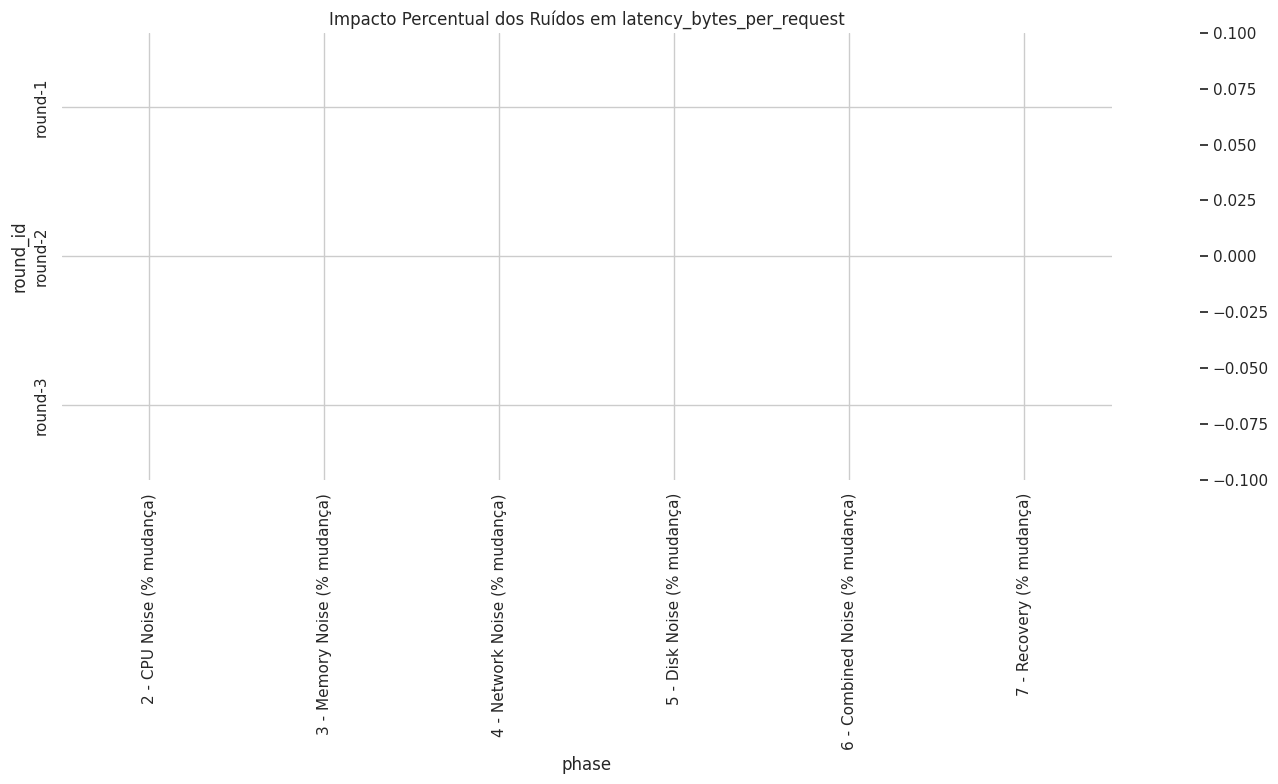

phase,1 - Baseline,2 - CPU Noise,3 - Memory Noise,4 - Network Noise,5 - Disk Noise,6 - Combined Noise,7 - Recovery,2 - CPU Noise (% mudança),3 - Memory Noise (% mudança),4 - Network Noise (% mudança),5 - Disk Noise (% mudança),6 - Combined Noise (% mudança),7 - Recovery (% mudança)
round_id,,,,,,,,,,,,,
round-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
round-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
round-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Analisar impacto do ruído na latência
analyze_noise_impact(df_clean, 'latency_bytes_per_request')

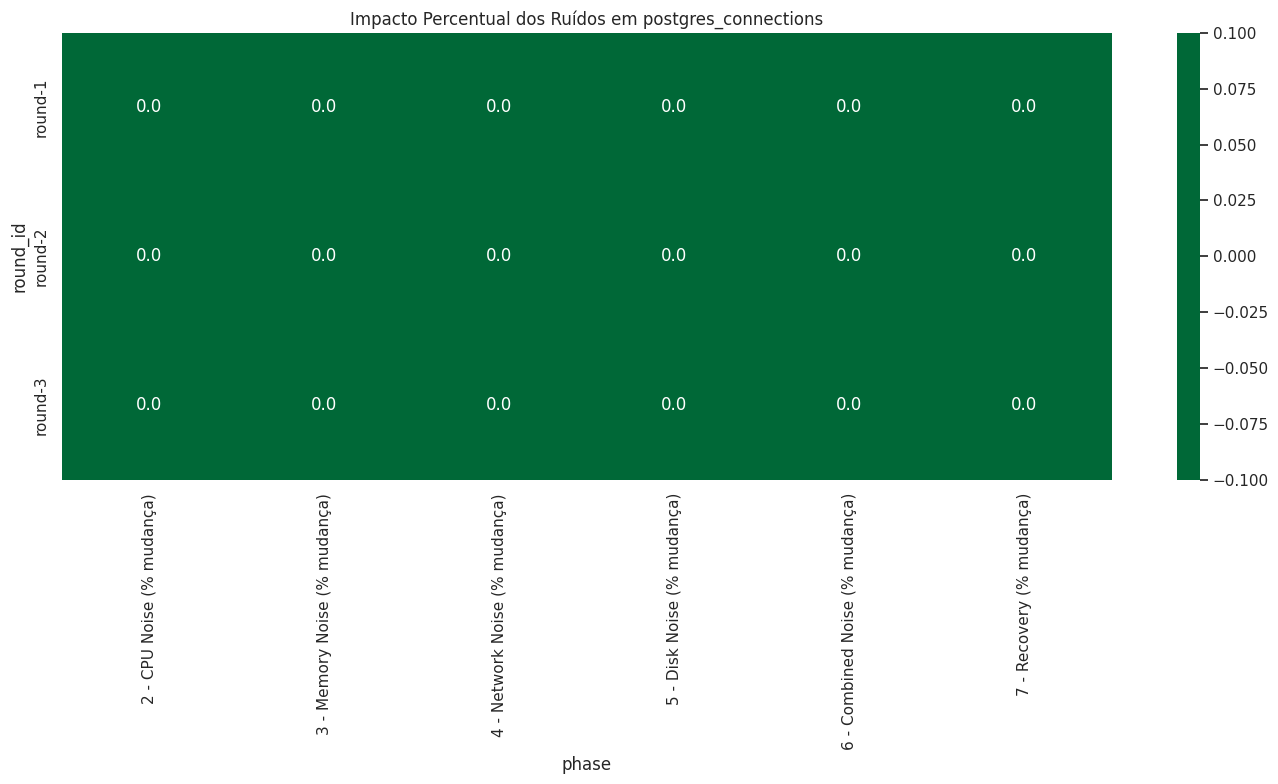

phase,1 - Baseline,2 - CPU Noise,3 - Memory Noise,4 - Network Noise,5 - Disk Noise,6 - Combined Noise,7 - Recovery,2 - CPU Noise (% mudança),3 - Memory Noise (% mudança),4 - Network Noise (% mudança),5 - Disk Noise (% mudança),6 - Combined Noise (% mudança),7 - Recovery (% mudança)
round_id,,,,,,,,,,,,,
round-1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
round-2,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
round-3,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Analisar impacto do ruído nas conexões do PostgreSQL
analyze_noise_impact(df_clean, 'postgres_connections')

## Análise de Série Temporal

Vamos analisar a evolução de uma métrica específica ao longo do tempo, comparando diferentes fases.

In [16]:
# Função para analisar séries temporais
def analyze_time_series(df, metric_name, component_name=None, round_id='round-1'):
    """
    Analisa a série temporal de uma métrica, mostrando a transição entre fases.
    """
    # Filtrar dados
    query = f"metric == '{metric_name}' and round_id == '{round_id}'"
    if component_name:
        query += f" and component == '{component_name}'"
    
    plot_df = df_clean.query(query).copy()
    
    if len(plot_df) == 0:
        print(f"Nenhum dado encontrado para a métrica {metric_name}")
        return
    
    # Converter timestamp para datetime se necessário
    if not pd.api.types.is_datetime64_any_dtype(plot_df['timestamp']):
        plot_df['timestamp'] = pd.to_datetime(plot_df['timestamp'])
    
    # Ordenar por timestamp
    plot_df = plot_df.sort_values('timestamp')
    
    # Criar gráfico
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plotar a série temporal
    sns.lineplot(x='timestamp', y='value', data=plot_df, ax=ax)
    
    # Adicionar linhas verticais para separar as fases
    phases = plot_df.sort_values('timestamp').drop_duplicates('phase', keep='first')
    
    for _, phase_row in phases.iterrows():
        ax.axvline(x=phase_row['timestamp'], color='red', linestyle='--', alpha=0.7)
        ax.text(phase_row['timestamp'], ax.get_ylim()[1] * 0.95, 
                phase_row['phase'], rotation=90, verticalalignment='top')
    
    title = f"Série Temporal de {metric_name} ({round_id})"
    if component_name:
        title += f" - {component_name}"
    
    ax.set_title(title)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Valor')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas por fase
    return plot_df.groupby('phase')['value'].describe()

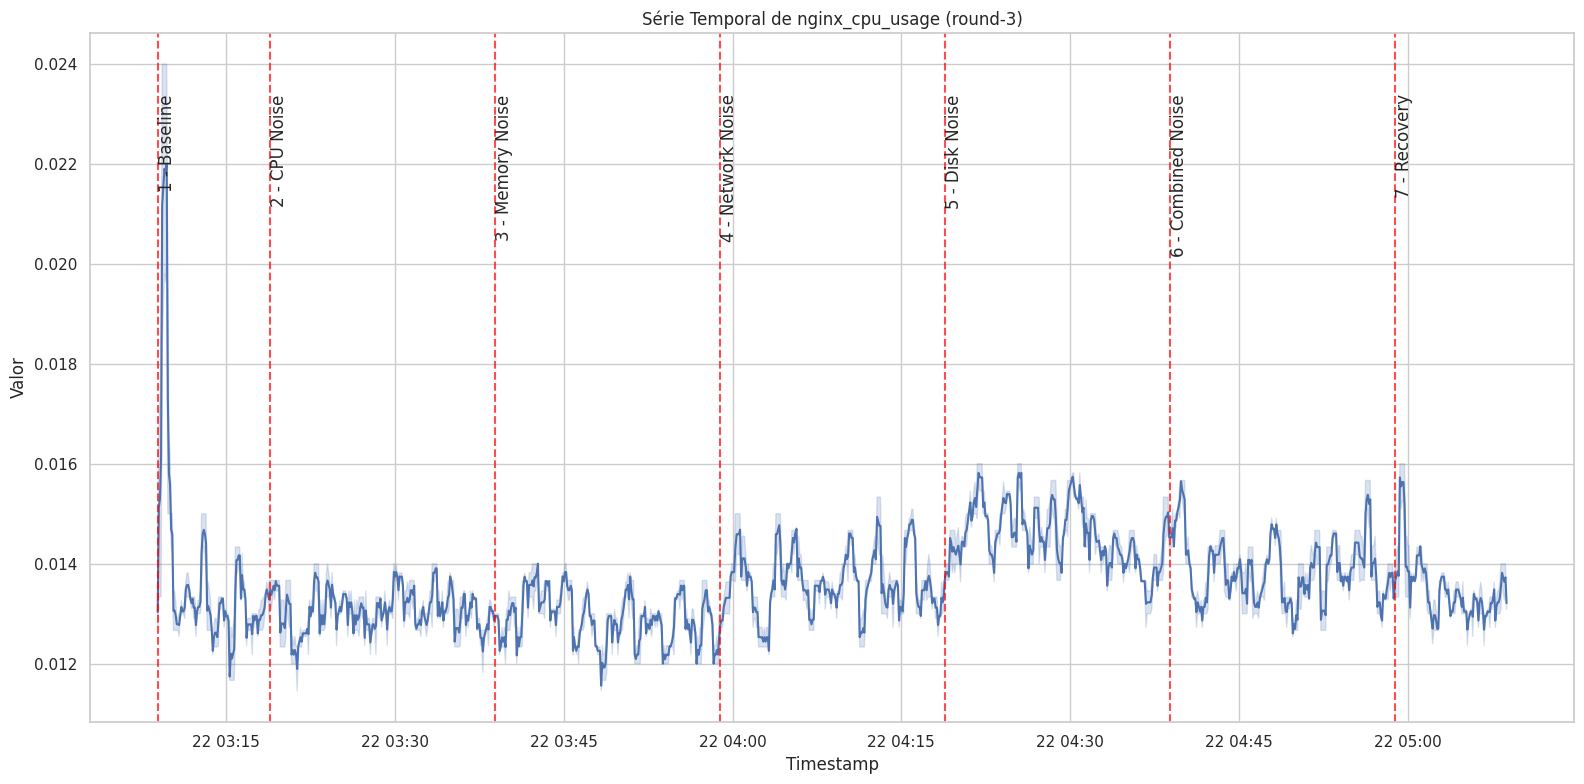

,count,mean,std,min,25%,50%,75%,max
phase,,,,,,,,
1 - Baseline,200.0,0.013746,0.002157,0.011667,0.012861,0.013268,0.013636,0.024000
2 - CPU Noise,400.0,0.013069,0.000451,0.011455,0.012727,0.013000,0.013333,0.014005
3 - Memory Noise,400.0,0.012899,0.000542,0.011455,0.012545,0.012911,0.013333,0.014000
4 - Network Noise,392.0,0.013608,0.000649,0.012182,0.013268,0.013636,0.014000,0.015333
5 - Disk Noise,379.0,0.014560,0.000652,0.012727,0.014000,0.014545,0.015000,0.016000
6 - Combined Noise,384.0,0.013864,0.000671,0.012545,0.013333,0.013818,0.014333,0.015667
7 - Recovery,200.0,0.013475,0.000659,0.012364,0.013000,0.013333,0.013667,0.016000


In [17]:
# Analisar a evolução do uso de CPU ao longo das fases
analyze_time_series(df_clean, 'nginx_cpu_usage', None, 'round-3')

## Análise de Correlação entre Métricas

Vamos analisar a correlação entre diferentes métricas para entender como elas se relacionam.

In [18]:
# Função para analisar correlação entre métricas
def analyze_metric_correlations(df, metrics_list, phase=None, round_id=None):
    """
    Analisa a correlação entre um conjunto de métricas.
    """
    # Filtrar dados
    query = f"metric in {metrics_list}"
    if phase:
        query += f" and phase == '{phase}'"
    if round_id:
        query += f" and round_id == '{round_id}'"
    
    plot_df = df_clean.query(query).copy()
    
    if len(plot_df) == 0:
        print(f"Nenhum dado encontrado para as métricas especificadas")
        return
    
    # Converter para formato amplo (wide format)
    # Agrupar por timestamp para ter todas as métricas na mesma linha
    pivot_df = plot_df.pivot_table(
        index=['timestamp', 'round_id', 'phase'],
        columns='metric',
        values='value'
    ).reset_index()
    
    # Calcular matriz de correlação
    corr_matrix = pivot_df[metrics_list].corr()
    
    # Visualizar matriz de correlação
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    
    title = "Correlação entre Métricas"
    if phase:
        title += f" (Fase: {phase})"
    if round_id:
        title += f" ({round_id})"
    
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

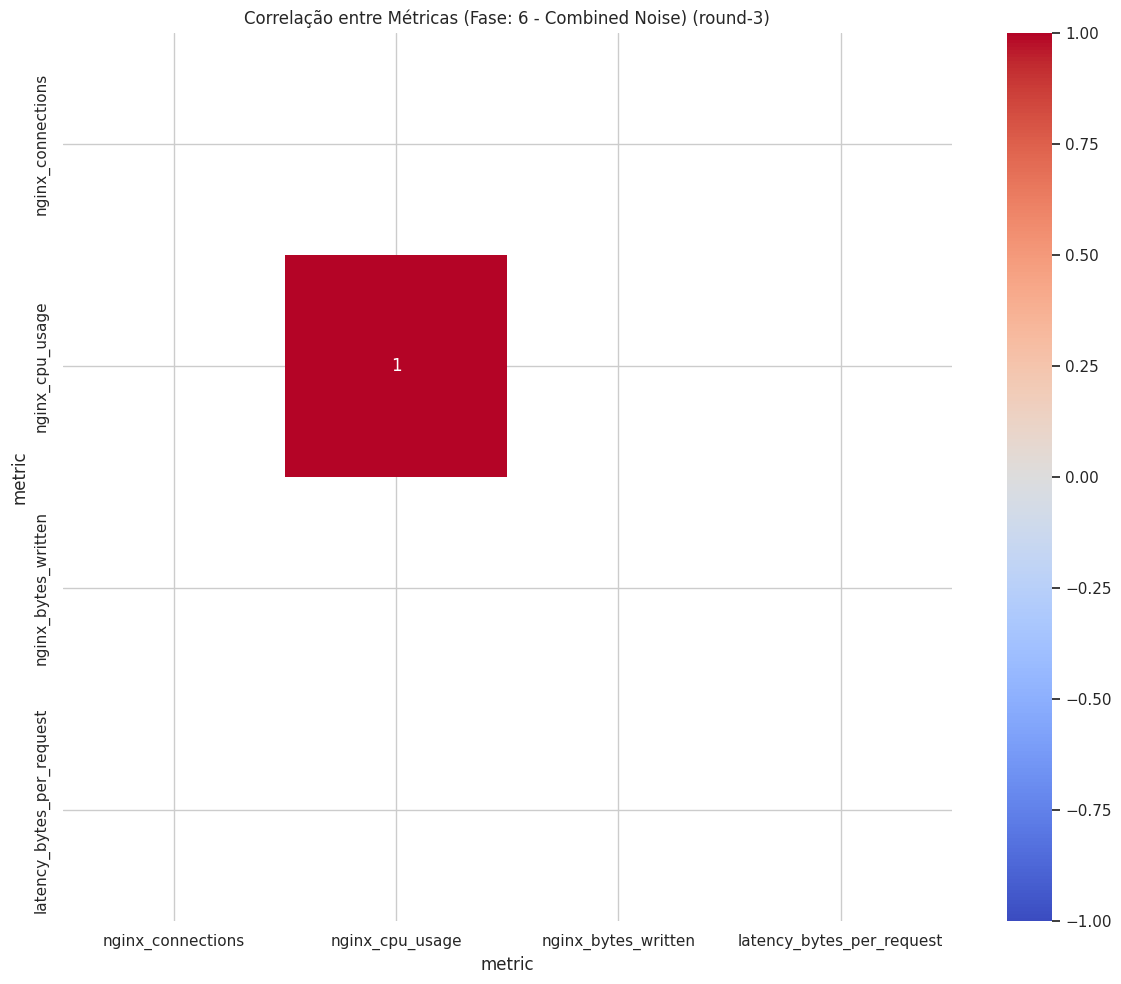

metric,nginx_connections,nginx_cpu_usage,nginx_bytes_written,latency_bytes_per_request
metric,,,,
nginx_connections,NaN,NaN,NaN,NaN
nginx_cpu_usage,NaN,1.0,NaN,NaN
nginx_bytes_written,NaN,NaN,NaN,NaN
latency_bytes_per_request,NaN,NaN,NaN,NaN


In [19]:
# Analisar correlação entre algumas métricas do Nginx durante ruído combinado
metrics_to_correlate = [
    'nginx_connections',
    'nginx_cpu_usage',
    'nginx_bytes_written',
    'latency_bytes_per_request'
]

analyze_metric_correlations(df_clean, metrics_to_correlate, '6 - Combined Noise', 'round-3')

## Exportando Resultados da Análise

Vamos demonstrar como exportar resultados de análises específicas para outros formatos.

In [20]:
# Exemplo: Exportar estatísticas de uma métrica específica por fase para CSV
def export_metric_stats(df, metric_name, output_path='./data/analysis_results/'):
    """
    Exporta estatísticas de uma métrica específica por fase e round.
    """
    import os
    
    # Filtrar para a métrica específica
    metric_df = df[df['metric'] == metric_name].copy()
    
    if len(metric_df) == 0:
        print(f"Nenhum dado encontrado para a métrica {metric_name}")
        return
    
    # Calcular estatísticas por fase e round
    stats_df = metric_df.groupby(['round_id', 'phase', 'component'])['value'].agg(
        ['count', 'mean', 'std', 'min', 'max']
    ).reset_index()
    
    # Criar diretório se não existir
    os.makedirs(output_path, exist_ok=True)
    
    # Exportar para CSV
    output_file = os.path.join(output_path, f"{metric_name}_stats.csv")
    stats_df.to_csv(output_file, index=False)
    
    print(f"Estatísticas para {metric_name} exportadas para {output_file}")
    
    return stats_df

In [21]:
# Exportar estatísticas para uma métrica importante
# export_metric_stats(df_clean, 'nginx_connections', './data/analysis_results/')

## Conclusão

Este notebook demonstrou como utilizar o arquivo Parquet consolidado para realizar análises dos dados do experimento SFI2. As principais vantagens do formato Parquet incluem:

1. **Carregamento rápido**: O formato Parquet é otimizado para leitura rápida de grandes conjuntos de dados.
2. **Economia de espaço**: Compressão eficiente dos dados.
3. **Preservação de tipos**: Os tipos de dados são preservados corretamente.
4. **Compatibilidade**: O formato é compatível com várias ferramentas de análise de dados.

As análises que podem ser realizadas incluem:

- Comparação entre diferentes fases do experimento
- Análise de impacto dos diferentes tipos de ruído
- Comparação entre diferentes rounds
- Análise de correlação entre métricas
- Análise de séries temporais